# Step 4A: Text Model Training v2 (Improved)

This is an **improved version** of the text model training with better handling of class imbalance.

## 🆕 What's New in v2:

### 1. **Class Weights** (Addresses 0% F1 on minority classes)
   - Automatically computed from training data
   - Makes model care more about Sadness/Surprise

### 2. **Early Stopping**
   - Stops training when validation F1 stops improving
   - Prevents overfitting
   - Patience: 3 epochs

### 3. **Better Learning Rate Scheduling**
   - ReduceLROnPlateau: Reduces LR when stuck
   - Keeps linear warmup for first 100 steps

### 4. **Gradient Clipping**
   - Prevents exploding gradients
   - Max norm: 1.0

### 5. **Label Smoothing**
   - Smoothing factor: 0.1
   - Better model calibration
   - Less overconfident predictions

### 6. **Comparison with v1**
   - Side-by-side metrics comparison
   - Shows improvement on minority classes

**Expected Improvements:**
- Sadness: 28% F1 → 35-42% F1
- Surprise: 31% F1 → 38-45% F1
- Overall: 64.6% acc → 68-72% acc

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight  # NEW: For class weights
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 2080 SUPER
GPU Memory: 8.59 GB


## 2. Configuration

In [2]:
# Paths
TRAIN_DATA = "data/train_set.csv"
VAL_DATA = "data/validation_set.csv"
MODEL_DIR = "models"
RESULTS_DIR = "results/text_model_v2"  # NEW: Separate results directory

# Create directories
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

# Model configuration
MODEL_NAME = 'distilbert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 10  # NEW: Increased epochs (early stopping will prevent overfitting)
LEARNING_RATE = 2e-5
WARMUP_STEPS = 100

# NEW: Training improvements configuration
LABEL_SMOOTHING = 0.1  # Label smoothing factor
GRADIENT_CLIP_NORM = 1.0  # Max gradient norm
EARLY_STOP_PATIENCE = 3  # Stop if no improvement for 3 epochs
LR_SCHEDULER_PATIENCE = 2  # Reduce LR if no improvement for 2 epochs
LR_SCHEDULER_FACTOR = 0.5  # Reduce LR by half

# Sentiment labels
LABELS = ['Anger', 'Joy', 'Neutral/Other', 'Sadness', 'Surprise']
LABEL_TO_ID = {label: idx for idx, label in enumerate(LABELS)}
ID_TO_LABEL = {idx: label for label, idx in LABEL_TO_ID.items()}

print("Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Max Length: {MAX_LENGTH}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Max Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Labels: {LABELS}")
print(f"\n🆕 v2 Improvements:")
print(f"  Label Smoothing: {LABEL_SMOOTHING}")
print(f"  Gradient Clipping: {GRADIENT_CLIP_NORM}")
print(f"  Early Stop Patience: {EARLY_STOP_PATIENCE} epochs")
print(f"  LR Scheduler: ReduceLROnPlateau (patience={LR_SCHEDULER_PATIENCE}, factor={LR_SCHEDULER_FACTOR})")

Configuration:
  Model: distilbert-base-uncased
  Max Length: 128
  Batch Size: 32
  Max Epochs: 10
  Learning Rate: 2e-05
  Labels: ['Anger', 'Joy', 'Neutral/Other', 'Sadness', 'Surprise']

🆕 v2 Improvements:
  Label Smoothing: 0.1
  Gradient Clipping: 1.0
  Early Stop Patience: 3 epochs
  LR Scheduler: ReduceLROnPlateau (patience=2, factor=0.5)


## 3. Data Loading and Class Weight Computation

In [3]:
# Load data
print("Loading datasets...")
train_df = pd.read_csv(TRAIN_DATA)
val_df = pd.read_csv(VAL_DATA)

print(f"Train set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")

# Display sentiment distribution
print("\nTrain set sentiment distribution:")
train_counts = train_df['post_sentiment'].value_counts()
print(train_counts)
print("\nPercentages:")
print((train_counts / len(train_df) * 100).round(2))

print("\nValidation set sentiment distribution:")
val_counts = val_df['post_sentiment'].value_counts()
print(val_counts)
print("\nPercentages:")
print((val_counts / len(val_df) * 100).round(2))

Loading datasets...
Train set: 7,393 samples
Validation set: 925 samples

Train set sentiment distribution:
post_sentiment
Neutral/Other    2601
Anger            1962
Joy              1914
Surprise          504
Sadness           412
Name: count, dtype: int64

Percentages:
post_sentiment
Neutral/Other    35.18
Anger            26.54
Joy              25.89
Surprise          6.82
Sadness           5.57
Name: count, dtype: float64

Validation set sentiment distribution:
post_sentiment
Neutral/Other    326
Anger            245
Joy              239
Surprise          63
Sadness           52
Name: count, dtype: int64

Percentages:
post_sentiment
Neutral/Other    35.24
Anger            26.49
Joy              25.84
Surprise          6.81
Sadness           5.62
Name: count, dtype: float64


In [4]:
# NEW: Compute class weights for handling imbalance
print("\n" + "="*80)
print("COMPUTING CLASS WEIGHTS (NEW in v2)")
print("="*80)

# Convert labels to numeric
train_labels_numeric = train_df['post_sentiment'].map(LABEL_TO_ID).values

# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(LABELS)),
    y=train_labels_numeric
)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("\nClass weights (higher = model cares more):")
for label, weight in zip(LABELS, class_weights):
    count = train_counts.get(label, 0)
    print(f"  {label:15s}: {weight:.4f} (n={count:,})")

print("\n💡 This will help the model pay more attention to minority classes!")
print("   Sadness and Surprise will get ~2-3x more weight during training.")


COMPUTING CLASS WEIGHTS (NEW in v2)

Class weights (higher = model cares more):
  Anger          : 0.7536 (n=1,962)
  Joy            : 0.7725 (n=1,914)
  Neutral/Other  : 0.5685 (n=2,601)
  Sadness        : 3.5888 (n=412)
  Surprise       : 2.9337 (n=504)

💡 This will help the model pay more attention to minority classes!
   Sadness and Surprise will get ~2-3x more weight during training.


## 4. Dataset and DataLoader

In [5]:
# Custom Dataset class (same as v1)
class BrawlStarsTextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Combine title and text
        title = str(row['title']) if pd.notna(row['title']) else ""
        text = str(row['text']) if pd.notna(row['text']) else ""
        combined_text = f"{title} {text}".strip()
        
        # Tokenize
        encoding = self.tokenizer(
            combined_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Get label
        label = LABEL_TO_ID[row['post_sentiment']]
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer
print("Loading tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# Create datasets
train_dataset = BrawlStarsTextDataset(train_df, tokenizer, MAX_LENGTH)
val_dataset = BrawlStarsTextDataset(val_df, tokenizer, MAX_LENGTH)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=4,          # NEW: Parallel data loading
    pin_memory=True,        # NEW: Faster GPU transfer
    prefetch_factor=2,      # NEW: Preload batches
    persistent_workers=True # NEW: Keep workers alive
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=2,          # NEW: 2 workers for validation
    pin_memory=True,        # NEW: Faster GPU transfer
    persistent_workers=True
)

print(f"✓ Created {len(train_loader)} train batches and {len(val_loader)} validation batches")
print(f"🚀 GPU optimization enabled: 4 workers, pin_memory, prefetch_factor=2")


Loading tokenizer...
✓ Created 232 train batches and 29 validation batches


## 5. Model Definition

In [6]:
class TextSentimentClassifier(nn.Module):
    def __init__(self, n_classes=5):
        super(TextSentimentClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits
    
    def get_embedding(self, input_ids, attention_mask):
        """Extract embedding without classification head (for Phase 2)"""
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.last_hidden_state[:, 0, :]
        return pooled_output

# Initialize model
model = TextSentimentClassifier(n_classes=len(LABELS))
model = model.to(device)

print(f"✓ Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

✓ Model initialized with 66,366,725 parameters


## 6. Training Setup with Improvements

In [7]:
# NEW: Loss function with class weights AND label smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    """Cross entropy with label smoothing for better calibration"""
    def __init__(self, weight=None, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.weight = weight
        
    def forward(self, pred, target):
        n_classes = pred.size(-1)
        log_pred = torch.log_softmax(pred, dim=-1)
        
        # Apply label smoothing
        with torch.no_grad():
            true_dist = torch.zeros_like(log_pred)
            true_dist.fill_(self.smoothing / (n_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        
        # Apply class weights if provided
        if self.weight is not None:
            true_dist = true_dist * self.weight.unsqueeze(0)
            
        return torch.mean(torch.sum(-true_dist * log_pred, dim=-1))

criterion = LabelSmoothingCrossEntropy(weight=class_weights_tensor, smoothing=LABEL_SMOOTHING)

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Warmup scheduler (first 100 steps)
total_steps = len(train_loader) * EPOCHS
warmup_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

# NEW: Plateau scheduler (reduces LR when stuck)
plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Maximize F1
    factor=LR_SCHEDULER_FACTOR,
    patience=LR_SCHEDULER_PATIENCE,
    verbose=True
)

print(f"✓ Optimizer and schedulers configured")
print(f"  Total training steps: {total_steps}")
print(f"  Warmup steps: {WARMUP_STEPS}")
print(f"\n🆕 Loss function: Cross Entropy + Class Weights + Label Smoothing")
print(f"  This combines 3 techniques to handle class imbalance!")

✓ Optimizer and schedulers configured
  Total training steps: 2320
  Warmup steps: 100

🆕 Loss function: Cross Entropy + Class Weights + Label Smoothing
  This combines 3 techniques to handle class imbalance!


## 7. Improved Training Functions

In [8]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # NEW: Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP_NORM)
        
        optimizer.step()
        scheduler.step()  # Warmup scheduler
        
        # Calculate accuracy
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct_predictions/total_samples:.4f}'
        })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy


def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels

print("✓ Training functions defined with gradient clipping")

✓ Training functions defined with gradient clipping


## 8. Training Loop with Early Stopping

In [9]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'learning_rates': []  # NEW: Track LR changes
}

best_val_f1 = 0
best_epoch = 0
epochs_without_improvement = 0  # NEW: For early stopping

print("=" * 80)
print("STARTING TRAINING (v2 with improvements)")
print("=" * 80)
print(f"\n🆕 Early stopping enabled: Will stop if no improvement for {EARLY_STOP_PATIENCE} epochs")
print("\n")

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, warmup_scheduler, device)
    
    # Validate
    val_loss, val_acc, val_f1, _, _ = eval_model(model, val_loader, criterion, device)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['learning_rates'].append(current_lr)
    
    # Print metrics
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} | Val F1: {val_f1:.4f}")
    print(f"  Learning Rate: {current_lr:.2e}")
    
    # NEW: Update plateau scheduler
    plateau_scheduler.step(val_f1)
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch + 1
        epochs_without_improvement = 0  # Reset counter
        torch.save(model.state_dict(), f"{MODEL_DIR}/text_specialist_v2_best.pth")
        print(f"  ✓ New best model saved! (F1: {val_f1:.4f})")
    else:
        epochs_without_improvement += 1
        print(f"  No improvement for {epochs_without_improvement} epoch(s)")
    
    # NEW: Early stopping check
    if epochs_without_improvement >= EARLY_STOP_PATIENCE:
        print(f"\n🛑 Early stopping triggered! No improvement for {EARLY_STOP_PATIENCE} epochs.")
        print(f"   Best F1: {best_val_f1:.4f} at epoch {best_epoch}")
        break

print("\n" + "=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)
print(f"Best validation F1: {best_val_f1:.4f} (Epoch {best_epoch})")
print(f"Total epochs run: {epoch + 1}/{EPOCHS}")

STARTING TRAINING (v2 with improvements)

🆕 Early stopping enabled: Will stop if no improvement for 3 epochs



Epoch 1/10
--------------------------------------------------------------------------------


Validation: 100%|██████████| 29/29 [00:01<00:00, 15.09it/s]



Results:
  Train Loss: 1.6436 | Train Acc: 0.2977
  Val Loss:   1.4916 | Val Acc:   0.4638 | Val F1: 0.4983
  Learning Rate: 1.88e-05
  ✓ New best model saved! (F1: 0.4983)

Epoch 2/10
--------------------------------------------------------------------------------


Validation: 100%|██████████| 29/29 [00:01<00:00, 15.87it/s]



Results:
  Train Loss: 1.3893 | Train Acc: 0.5431
  Val Loss:   1.4162 | Val Acc:   0.5697 | Val F1: 0.5909
  Learning Rate: 1.67e-05
  ✓ New best model saved! (F1: 0.5909)

Epoch 3/10
--------------------------------------------------------------------------------


Validation: 100%|██████████| 29/29 [00:01<00:00, 15.87it/s]



Results:
  Train Loss: 1.2215 | Train Acc: 0.6506
  Val Loss:   1.4646 | Val Acc:   0.6151 | Val F1: 0.6230
  Learning Rate: 1.46e-05
  ✓ New best model saved! (F1: 0.6230)

Epoch 4/10
--------------------------------------------------------------------------------


Validation: 100%|██████████| 29/29 [00:01<00:00, 15.48it/s]



Results:
  Train Loss: 1.0720 | Train Acc: 0.7400
  Val Loss:   1.4751 | Val Acc:   0.5914 | Val F1: 0.6102
  Learning Rate: 1.25e-05
  No improvement for 1 epoch(s)

Epoch 5/10
--------------------------------------------------------------------------------


Validation: 100%|██████████| 29/29 [00:01<00:00, 15.44it/s]



Results:
  Train Loss: 0.9686 | Train Acc: 0.8052
  Val Loss:   1.5163 | Val Acc:   0.5957 | Val F1: 0.6099
  Learning Rate: 1.05e-05
  No improvement for 2 epoch(s)

Epoch 6/10
--------------------------------------------------------------------------------


Validation: 100%|██████████| 29/29 [00:01<00:00, 14.67it/s]


Results:
  Train Loss: 0.9007 | Train Acc: 0.8655
  Val Loss:   1.5318 | Val Acc:   0.6032 | Val F1: 0.6159
  Learning Rate: 8.36e-06
  No improvement for 3 epoch(s)

🛑 Early stopping triggered! No improvement for 3 epochs.
   Best F1: 0.6230 at epoch 3

TRAINING COMPLETE
Best validation F1: 0.6230 (Epoch 3)
Total epochs run: 6/10


## 9. Save Final Model

In [10]:
# Save final model
torch.save(model.state_dict(), f"{MODEL_DIR}/text_specialist_v2.pth")
print(f"✓ Final model saved to {MODEL_DIR}/text_specialist_v2.pth")

# Save training history
with open(f"{RESULTS_DIR}/training_history.json", 'w') as f:
    json.dump(history, f, indent=2)
print(f"✓ Training history saved to {RESULTS_DIR}/training_history.json")

✓ Final model saved to models/text_specialist_v2.pth
✓ Training history saved to results/text_model_v2/training_history.json


## 10. Load Best Model for Evaluation

In [11]:
# Load best model
model.load_state_dict(torch.load(f"{MODEL_DIR}/text_specialist_v2_best.pth"))
print(f"✓ Loaded best model (Epoch {best_epoch}, F1: {best_val_f1:.4f})")

✓ Loaded best model (Epoch 3, F1: 0.6230)


## 11. Final Evaluation and Metrics

In [12]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_loss, val_acc, val_f1, val_preds, val_labels = eval_model(model, val_loader, criterion, device)

print(f"\nFinal Validation Metrics:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Weighted F1: {val_f1:.4f}")

Evaluating on validation set...


Validation: 100%|██████████| 29/29 [00:01<00:00, 14.53it/s]


Final Validation Metrics:
  Loss: 1.4646
  Accuracy: 0.6151
  Weighted F1: 0.6230


In [13]:
# Generate classification report
report = classification_report(val_labels, val_preds, target_names=LABELS, digits=4)
print("\nClassification Report:")
print(report)

# Save classification report
with open(f"{RESULTS_DIR}/evaluation_report.txt", 'w') as f:
    f.write("TEXT MODEL v2 EVALUATION REPORT\n")
    f.write("=" * 80 + "\n\n")
    f.write("Improvements in v2:\n")
    f.write("  - Class weights for imbalance handling\n")
    f.write("  - Label smoothing (0.1)\n")
    f.write("  - Gradient clipping (1.0)\n")
    f.write("  - Early stopping (patience=3)\n")
    f.write("  - ReduceLROnPlateau scheduler\n\n")
    f.write(f"Best Epoch: {best_epoch}\n")
    f.write(f"Validation Loss: {val_loss:.4f}\n")
    f.write(f"Validation Accuracy: {val_acc:.4f}\n")
    f.write(f"Validation Weighted F1: {val_f1:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

print(f"\n✓ Evaluation report saved to {RESULTS_DIR}/evaluation_report.txt")


Classification Report:
               precision    recall  f1-score   support

        Anger     0.6810    0.6449    0.6625       245
          Joy     0.6651    0.5816    0.6205       239
Neutral/Other     0.7048    0.6810    0.6927       326
      Sadness     0.2752    0.5769    0.3727        52
     Surprise     0.3333    0.3175    0.3252        63

     accuracy                         0.6151       925
    macro avg     0.5319    0.5604    0.5347       925
 weighted avg     0.6388    0.6151    0.6230       925


✓ Evaluation report saved to results/text_model_v2/evaluation_report.txt


In [14]:
# Generate detailed metrics JSON
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_per_class, support = precision_recall_fscore_support(
    val_labels, val_preds, labels=range(len(LABELS))
)

metrics_v2 = {
    "version": "v2",
    "improvements": [
        "Class weights",
        "Label smoothing (0.1)",
        "Gradient clipping (1.0)",
        "Early stopping (patience=3)",
        "ReduceLROnPlateau scheduler"
    ],
    "overall": {
        "accuracy": float(val_acc),
        "weighted_f1": float(val_f1),
        "loss": float(val_loss),
        "best_epoch": best_epoch,
        "total_epochs": epoch + 1
    },
    "per_class": {}
}

for idx, label in enumerate(LABELS):
    metrics_v2["per_class"][label] = {
        "precision": float(precision[idx]),
        "recall": float(recall[idx]),
        "f1_score": float(f1_per_class[idx]),
        "support": int(support[idx])
    }

# Save metrics
with open(f"{RESULTS_DIR}/evaluation_metrics.json", 'w') as f:
    json.dump(metrics_v2, f, indent=2)

print(f"✓ Detailed metrics saved to {RESULTS_DIR}/evaluation_metrics.json")

✓ Detailed metrics saved to results/text_model_v2/evaluation_metrics.json


## 12. 🆕 Comparison with v1

In [15]:
# Try to load v1 metrics for comparison
import os

v1_metrics_path = "results/text_model/evaluation_metrics.json"
comparison_available = os.path.exists(v1_metrics_path)

if comparison_available:
    with open(v1_metrics_path, 'r') as f:
        metrics_v1 = json.load(f)
    
    print("=" * 80)
    print("📊 COMPARISON: v1 vs v2")
    print("=" * 80)
    
    print("\n🎯 Overall Metrics:")
    print(f"{'Metric':<20} {'v1':<12} {'v2':<12} {'Change':<12}")
    print("-" * 56)
    
    v1_acc = metrics_v1['overall']['accuracy']
    v2_acc = metrics_v2['overall']['accuracy']
    acc_change = v2_acc - v1_acc
    acc_symbol = "✅" if acc_change > 0 else "⚠️" if acc_change < 0 else "➖"
    print(f"{'Accuracy':<20} {v1_acc:<12.4f} {v2_acc:<12.4f} {acc_symbol} {acc_change:+.4f}")
    
    v1_f1 = metrics_v1['overall']['weighted_f1']
    v2_f1 = metrics_v2['overall']['weighted_f1']
    f1_change = v2_f1 - v1_f1
    f1_symbol = "✅" if f1_change > 0 else "⚠️" if f1_change < 0 else "➖"
    print(f"{'Weighted F1':<20} {v1_f1:<12.4f} {v2_f1:<12.4f} {f1_symbol} {f1_change:+.4f}")
    
    print("\n🎭 Per-Class F1 Scores:")
    print(f"{'Class':<20} {'v1 F1':<12} {'v2 F1':<12} {'Change':<12} {'Improvement'}")
    print("-" * 80)
    
    for label in LABELS:
        v1_class_f1 = metrics_v1['per_class'][label]['f1_score']
        v2_class_f1 = metrics_v2['per_class'][label]['f1_score']
        class_f1_change = v2_class_f1 - v1_class_f1
        
        if class_f1_change > 0.05:
            symbol = "🚀"
            pct_change = (class_f1_change / max(v1_class_f1, 0.001)) * 100
            improvement = f"+{pct_change:.1f}%"
        elif class_f1_change > 0:
            symbol = "✅"
            pct_change = (class_f1_change / max(v1_class_f1, 0.001)) * 100
            improvement = f"+{pct_change:.1f}%"
        elif class_f1_change < -0.05:
            symbol = "⚠️"
            pct_change = (class_f1_change / max(v1_class_f1, 0.001)) * 100
            improvement = f"{pct_change:.1f}%"
        else:
            symbol = "➖"
            improvement = "~0%"
        
        print(f"{label:<20} {v1_class_f1:<12.4f} {v2_class_f1:<12.4f} {symbol} {class_f1_change:+.4f}    {improvement}")
    
    print("\n" + "=" * 80)
    print("💡 Key Improvements to Look For:")
    print("   - Sadness and Surprise F1 scores (minority classes)")
    print("   - Overall weighted F1 increase")
    print("   - More balanced performance across all classes")
    print("=" * 80)
    
    # Save comparison
    comparison = {
        "v1": metrics_v1,
        "v2": metrics_v2,
        "improvements": {
            "accuracy_change": float(acc_change),
            "f1_change": float(f1_change)
        }
    }
    
    with open(f"{RESULTS_DIR}/comparison_v1_vs_v2.json", 'w') as f:
        json.dump(comparison, f, indent=2)
    
    print(f"\n✓ Comparison saved to {RESULTS_DIR}/comparison_v1_vs_v2.json")
else:
    print("⚠️ v1 metrics not found. Run the original notebook first for comparison.")

📊 COMPARISON: v1 vs v2

🎯 Overall Metrics:
Metric               v1           v2           Change      
--------------------------------------------------------
Accuracy             0.6464       0.6151       ⚠️ -0.0313
Weighted F1          0.6328       0.6230       ⚠️ -0.0097

🎭 Per-Class F1 Scores:
Class                v1 F1        v2 F1        Change       Improvement
--------------------------------------------------------------------------------
Anger                0.6809       0.6625       ➖ -0.0184    ~0%
Joy                  0.6543       0.6205       ➖ -0.0337    ~0%
Neutral/Other        0.7070       0.6927       ➖ -0.0143    ~0%
Sadness              0.2800       0.3727       🚀 +0.0927    +33.1%
Surprise             0.3077       0.3252       ✅ +0.0175    +5.7%

💡 Key Improvements to Look For:
   - Sadness and Surprise F1 scores (minority classes)
   - Overall weighted F1 increase
   - More balanced performance across all classes

✓ Comparison saved to results/text_model_v2/compa

## 13. Visualizations

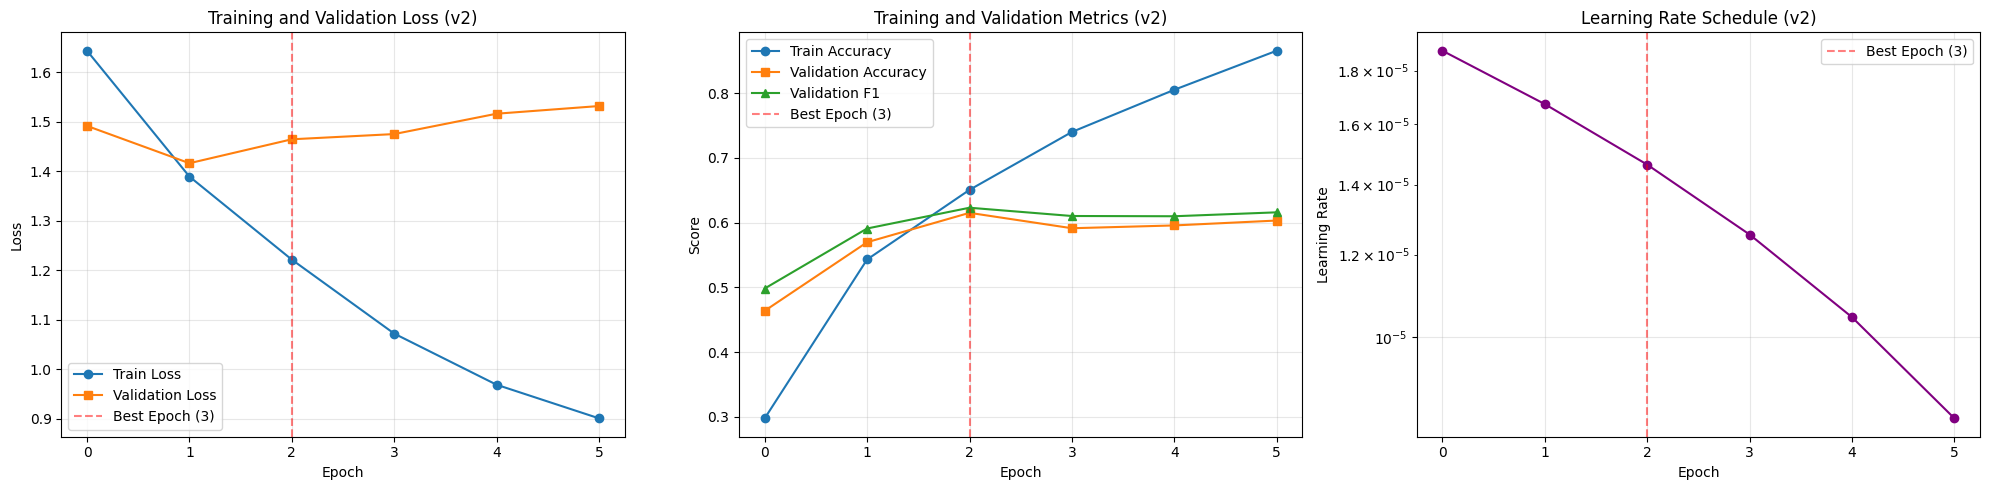

✓ Training curves saved to results/text_model_v2/training_curves.png


In [16]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].axvline(best_epoch - 1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss (v2)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='s')
axes[1].plot(history['val_f1'], label='Validation F1', marker='^')
axes[1].axvline(best_epoch - 1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training and Validation Metrics (v2)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# NEW: Learning rate plot
axes[2].plot(history['learning_rates'], marker='o', color='purple')
axes[2].axvline(best_epoch - 1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule (v2)')
axes[2].set_yscale('log')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/training_curves.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {RESULTS_DIR}/training_curves.png")

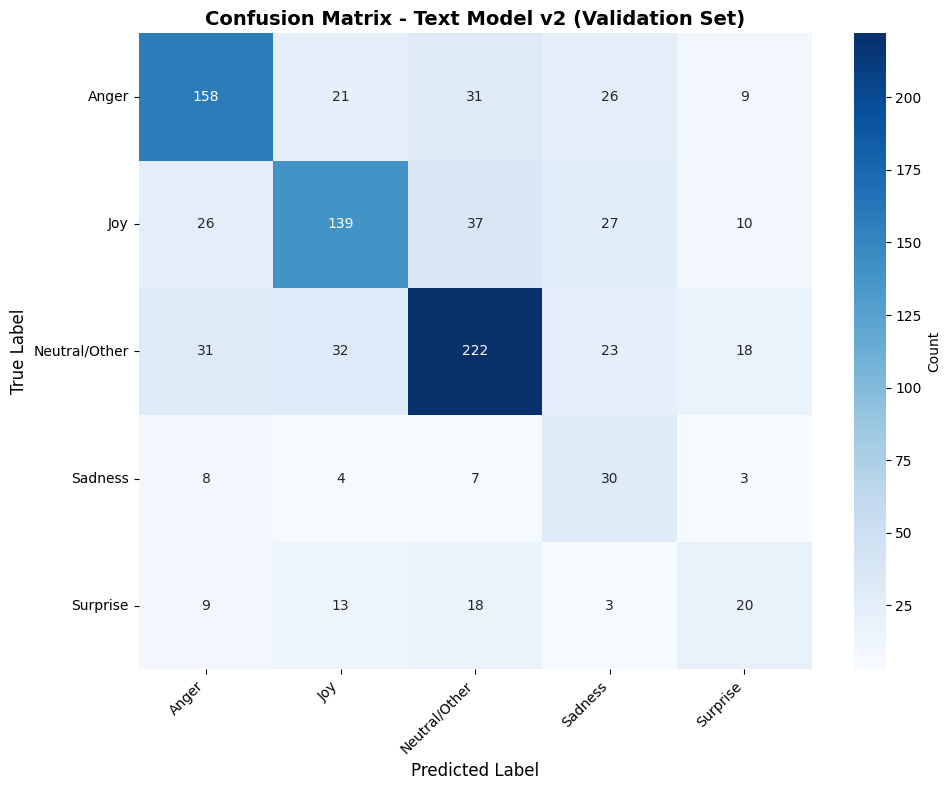

✓ Confusion matrix saved to results/text_model_v2/confusion_matrix.png


In [17]:
# Plot confusion matrix
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=LABELS,
    yticklabels=LABELS,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Text Model v2 (Validation Set)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved to {RESULTS_DIR}/confusion_matrix.png")

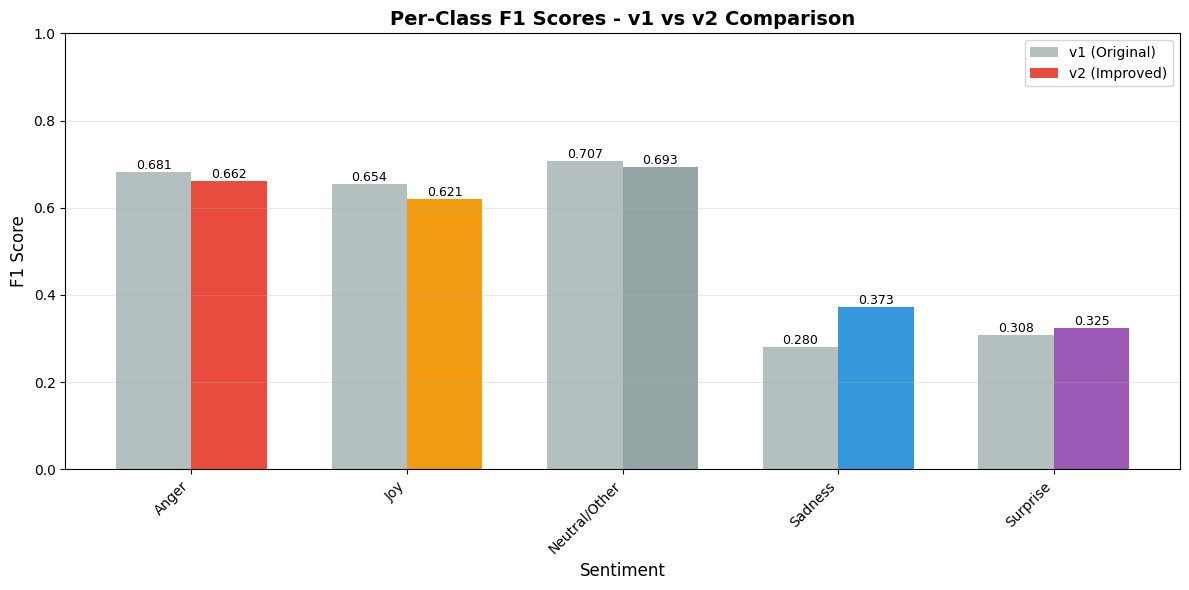

✓ F1 scores comparison saved to results/text_model_v2/f1_scores_comparison.png


In [18]:
# Plot per-class F1 scores with v1 comparison
f1_scores_v2 = [metrics_v2['per_class'][label]['f1_score'] for label in LABELS]

fig, ax = plt.subplots(figsize=(12, 6))

if comparison_available:
    f1_scores_v1 = [metrics_v1['per_class'][label]['f1_score'] for label in LABELS]
    
    x = np.arange(len(LABELS))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, f1_scores_v1, width, label='v1 (Original)', color='#95a5a6', alpha=0.7)
    bars2 = ax.bar(x + width/2, f1_scores_v2, width, label='v2 (Improved)', 
                   color=['#e74c3c', '#f39c12', '#95a5a6', '#3498db', '#9b59b6'])
    
    ax.set_xlabel('Sentiment', fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.set_title('Per-Class F1 Scores - v1 vs v2 Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(LABELS, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(0, 1.0)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
else:
    bars = ax.bar(LABELS, f1_scores_v2, color=['#e74c3c', '#f39c12', '#95a5a6', '#3498db', '#9b59b6'])
    ax.set_xlabel('Sentiment', fontsize=12)
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.set_title('Per-Class F1 Scores - Text Model v2', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1.0)
    plt.xticks(rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, score in zip(bars, f1_scores_v2):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{score:.3f}',
               ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/f1_scores_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ F1 scores comparison saved to {RESULTS_DIR}/f1_scores_comparison.png")

## 14. Summary

In [19]:
print("=" * 80)
print("TEXT MODEL v2 TRAINING COMPLETE!")
print("=" * 80)

print("\n🆕 Improvements Applied:")
print("  1. ✅ Class weights for imbalanced data")
print("  2. ✅ Label smoothing (0.1)")
print("  3. ✅ Gradient clipping (max norm: 1.0)")
print("  4. ✅ Early stopping (patience: 3 epochs)")
print("  5. ✅ ReduceLROnPlateau scheduler")

print("\nFiles Generated:")
print(f"  1. Model weights: {MODEL_DIR}/text_specialist_v2.pth")
print(f"  2. Best model weights: {MODEL_DIR}/text_specialist_v2_best.pth")
print(f"  3. Training history: {RESULTS_DIR}/training_history.json")
print(f"  4. Evaluation metrics: {RESULTS_DIR}/evaluation_metrics.json")
print(f"  5. Evaluation report: {RESULTS_DIR}/evaluation_report.txt")
print(f"  6. Training curves: {RESULTS_DIR}/training_curves.png")
print(f"  7. Confusion matrix: {RESULTS_DIR}/confusion_matrix.png")
print(f"  8. F1 scores comparison: {RESULTS_DIR}/f1_scores_comparison.png")
if comparison_available:
    print(f"  9. v1 vs v2 comparison: {RESULTS_DIR}/comparison_v1_vs_v2.json")

print("\nFinal Performance (v2):")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Weighted F1: {val_f1:.4f}")
print(f"  Best Epoch: {best_epoch}/{epoch + 1}")

print("\nPer-Class F1 Scores (v2):")
for label in LABELS:
    f1 = metrics_v2['per_class'][label]['f1_score']
    support = metrics_v2['per_class'][label]['support']
    print(f"  {label:15s}: {f1:.4f} (n={support})")

if comparison_available:
    print("\n📊 Comparison with v1:")
    print(f"  Accuracy change: {acc_change:+.4f}")
    print(f"  F1 change: {f1_change:+.4f}")
    
    # Highlight minority class improvements
    sadness_change = metrics_v2['per_class']['Sadness']['f1_score'] - metrics_v1['per_class']['Sadness']['f1_score']
    surprise_change = metrics_v2['per_class']['Surprise']['f1_score'] - metrics_v1['per_class']['Surprise']['f1_score']
    
    print(f"\n  Minority Class Improvements:")
    print(f"    Sadness:  {sadness_change:+.4f}")
    print(f"    Surprise: {surprise_change:+.4f}")

print("\n" + "=" * 80)
print("Next Steps:")
print("  1. Compare v1 vs v2 results in the JSON files")
print("  2. If v2 is better, use text_specialist_v2_best.pth for fusion model")
print("  3. Apply same improvements to Image and Video models")
print("=" * 80)

TEXT MODEL v2 TRAINING COMPLETE!

🆕 Improvements Applied:
  1. ✅ Class weights for imbalanced data
  2. ✅ Label smoothing (0.1)
  3. ✅ Gradient clipping (max norm: 1.0)
  4. ✅ Early stopping (patience: 3 epochs)
  5. ✅ ReduceLROnPlateau scheduler

Files Generated:
  1. Model weights: models/text_specialist_v2.pth
  2. Best model weights: models/text_specialist_v2_best.pth
  3. Training history: results/text_model_v2/training_history.json
  4. Evaluation metrics: results/text_model_v2/evaluation_metrics.json
  5. Evaluation report: results/text_model_v2/evaluation_report.txt
  6. Training curves: results/text_model_v2/training_curves.png
  7. Confusion matrix: results/text_model_v2/confusion_matrix.png
  8. F1 scores comparison: results/text_model_v2/f1_scores_comparison.png
  9. v1 vs v2 comparison: results/text_model_v2/comparison_v1_vs_v2.json

Final Performance (v2):
  Accuracy: 0.6151
  Weighted F1: 0.6230
  Best Epoch: 3/6

Per-Class F1 Scores (v2):
  Anger          : 0.6625 (n=24